In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import ipywidgets as widgets
from ipywidgets import interact  
import datetime
from dateutil.relativedelta import relativedelta
from workadays import workdays as wd
from sklearn.linear_model import LinearRegression

# Comparador de investimentos

Este notebook serve de base para a criação de uma aplicação capaz de comparar o rendimento líquido de um investimento em CDB (com imposto de renda) com um LCI ou LCA (sem imposto de renda).

A ideia da aplicação é saber qual investimento em LCI ou LCA é financeiramente equivalente a um rendimento em CDB para um determinado prazo.

Para facilitar os cálculos, defini as constantes referentes a taxa DI anualizada e C que se refere a taxa DI diária calculada a partir da taxa anualizada. Ambas taxas são percentuais.

In [12]:
# a taxa di precisa estar atualizada
taxaDI = 0.1125
C = (1+taxaDI)**(1/252) - 1

Para fazermos a comparação de investimentos, primeiramente vamos definir o prazo do investimento. Estamos definindo abaixo a data de hoje para o início e um ano depois para o fim. Na aplicação, a e b serão entradas.

In [67]:
# entradas da aplicação
a = datetime.date.today()
b = a+relativedelta(years=2)

O cálculo de rendimento depende do número n de dias úteis entre o início e o fim do prazo. Já o cálculo do imposto do CDB depende dos N dias corridos. Calculamos N e n com a com a função abaixo:

In [68]:
def contador(a, b):
    N = (b-a).days
    n = wd.networkdays(a, b)
    return N, n

Definimos uma função que retorna o percentual de imposto cobrado sobre o rendimento em função do número de dias corridos para um CDB:

In [69]:
def imposto(N):
    if N<=180:
        return 0.225
    elif N<=360:
        return 0.20
    elif N<=720:
        return 0.175
    else:
        return 0.15

Definimos abaixo funções que retornam o rendimento líquido de um CDB e de um LCI ou LCA. Para isso, precisamos definir um prazo e fornecer o percentual do CDI que rende a aplicação.

In [71]:
@np.vectorize
def R_CDB(a, b, P):
    N, n = contador(a, b)
    rendimento = 100*( ((C*0.01*P + 1)**n - 1) * (1-imposto(N)) )
    return rendimento

@np.vectorize
def R_LCI(a, b, P):
    N, n = contador(a, b)
    return 100*((C*0.01*P + 1)**n - 1)

Abaixo igualamos as expressões para o rendimento do CDB com o LCI/LCA e isolamos o percentual de rendimento do LCI. Com isso, dado um percentual de rendimento para um CBD, podemos calcular o percentual de rendimento de um LCI/ LCA com o mesmo rendimento líquido.

In [72]:
@np.vectorize
def P_LCI(a, b, P_CDB):
    N, n = contador(a, b)
    return 100*((( ((C*0.01*P_CDB+1)**n -1)*(1-imposto(N))) + 1)**(1/n) -1) / C

Abaixo igualamos as expressões para o rendimento do CDB com o LCI/LCA e isolamos o percentual de rendimento do CDB. Com isso, dado um percentual de rendimento para um LCI/LCA, podemos calcular o percentual de rendimento de um CDB com o mesmo rendimento líquido.

In [73]:
@np.vectorize
def P_CDB(a, b, P_LCI):
    N, n = contador(a, b)
    return 100*( (((C*0.01*P_LCI+1)**n - 1)/(1-imposto(N)) + 1 )**(1/n) -1) / C

Testando para alguns valores:

In [74]:
# rendimento de um CDB que rende 100% do CDI
R_CDB(a, b, 100).item()

20.20078125000129

In [75]:
# rendimento de um LCI que rende 83.25% do CDI
R_LCI(a, b, 83.25).item()

19.424178854255825

In [76]:
# Qual LCI equivale a um CDB rendendo 100% do CDI
P_LCI(a, b, 100).item()

86.29043143491175

In [77]:
# Qual CDB equivale a um LCI rendendo 83.25% do CDI
P_CDB(a, b, 83.25).item()

96.52424204521759

Vamos gerar um gráfico que mostra o rendimento nos prazos dados:

In [78]:
tempo = pd.date_range(a, b)
dias = [tempo[i].date() for i in range(len(tempo))][1:]

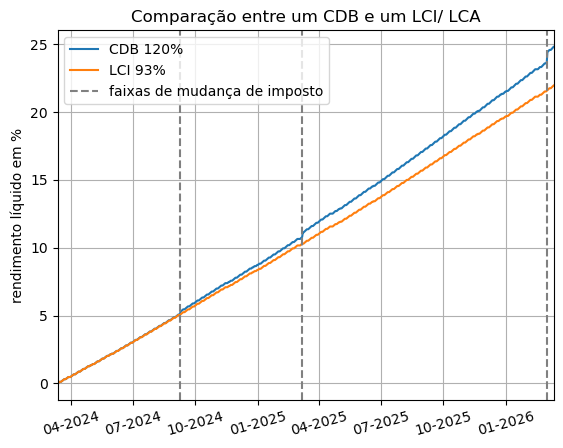

In [80]:
fig, ax = plt.subplots()

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=15)
        
cdb = 120
lci = 93

ax.plot(dias, R_CDB(a, dias, cdb), label=f'CDB {cdb}%')
ax.plot(dias, R_LCI(a, dias, lci), label=f'LCI {lci}%')
date_form = DateFormatter('%m-%Y')
ax.xaxis.set_major_formatter(date_form)
ax.set_xlim(a, b)

ax.axvline(a+relativedelta(days=180), color='gray', linestyle='dashed', label='faixas de mudança de imposto')
ax.axvline(a+relativedelta(days=360), color='gray', linestyle='dashed')
ax.axvline(a+relativedelta(days=720), color='gray', linestyle='dashed')

ax.set_title('Comparação entre um CDB e um LCI/ LCA')
ax.set_ylabel('rendimento líquido em %')
ax.legend(loc='upper left', ncols=1)

ax.grid()


